### Data preprocessing

The raw 2D X-ray diffraction (XRD) data were acquired on a 141 × 121 real-space scan grid, with a 2D detector image recorded at each scan position. The raw detector frames have a size of 512 × 1028 pixels and are stored as uint32 values.

The following preprocessing steps were applied:

- The detector images were cropped to the left 512 × 512 pixel region.
- The data were converted from uint32 to float32.
- Invalid detector pixels marked by the sentinel value (2³² − 1) were replaced with zero.
- A variance-stabilizing transform was applied to the intensities:
  
  \[
  I \rightarrow \sqrt{\max(I, 0) + 0.375}
  \]

No averaging over scan positions was performed. No normalization, intensity clipping, background subtraction, or flat-field/dark-field correction was applied. The processed data were saved in HDF5 format using gzip compression, which does not modify the pixel values.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import h5py
import hdf5plugin
from tqdm.notebook import tqdm
from scipy.ndimage import median_filter, center_of_mass
from pathlib import Path

In [12]:
data_path = "../data/000278.h5"
OUT_ROOT = Path("../data/exports_processed_clean_win0")

In [ ]:
datah5 = h5py.File(data_path, 'r')
frames = datah5['entry/measurement/eiger500k/frames'][:] # is faster to load the frames like this as a chunk
scan = datah5['entry/description'][:]
print(scan)
datah5.close()

[b'npointflyscan sx 0.5 6.5 120 sy -2 5 140 0.1']


In [5]:
reshape_frames = np.reshape(frames, (141, 121, 512, 1028))

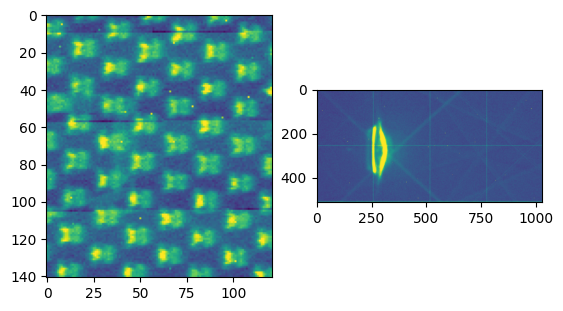

In [6]:
fig, ax = plt.subplots(1, 2)
total_Real = np.sum(reshape_frames, axis = (2, 3))
ax[0].imshow(total_Real, vmax = np.percentile(total_Real, 99))
total_RSM = np.sum(reshape_frames, axis = (0, 1))
ax[1].imshow(total_RSM, vmax = np.percentile(total_RSM, 99))

### Export processed detector dataset 

This cell builds ML-ready HDF5 datasets directly from `reshape_frames` (in memory).

- Output: two HDF5 files (one per `win`) under `OUT_ROOT/winXX/processed_winXX_left512.h5`
  - dataset name: `img`
  - shape: `(H, W, 512, 512)` (fixed left crop from the 512×1028 detector)
- `win=0`: single-pixel detector frames (no scan-grid averaging)
- `win=10`: scan-grid window-mean detector frames (21×21 neighborhood) computed via an integral-image box sum
- Preprocessing options:
  - `BAD_TO_ZERO`: replace Eiger bad value (`2**32-1`) with 0
  - `USE_VST`: apply VST `sqrt(max(x,0)+0.375)`
- Performance: uses `ProcessPoolExecutor` to compute detector tiles in parallel; the main process writes results to HDF5.


In [ ]:
import numpy as np
import h5py
from pathlib import Path
from datetime import datetime

# =========================
# USER CONFIG
# =========================
#OUT_ROOT = Path("../data/exports_processed_clean_win0")
WINS = [0]                 # 0 => single, 10 => 21x21 window mean on scan grid
TILE_H, TILE_W = 32, 64        # detector tiling (within 512x512 after crop)
COMPRESSION = "gzip"           # "gzip" or "lzf"
GZIP_LEVEL = 4
PRINT_EVERY = 5

# processing toggles (match your UI)
BAD_TO_ZERO = True
USE_VST = True                 # sqrt(x+0.375)
# =========================

assert "reshape_frames" in globals()
assert "total_Real" in globals()

H, W = total_Real.shape
detH, detW = reshape_frames.shape[2], reshape_frames.shape[3]
assert detH == 512, "This script assumes detector height is 512."
CROP_W = detH                   # left 512 columns
BAD = np.uint32(2**32 - 1)

OUT_ROOT.mkdir(parents=True, exist_ok=True)

# -------------------------
# Precompute box indices for win>0
# -------------------------
def _precompute_box_indices(win):
    y = np.arange(H)
    x = np.arange(W)
    y0 = np.clip(y - win, 0, H)
    y1 = np.clip(y + win + 1, 0, H)
    x0 = np.clip(x - win, 0, W)
    x1 = np.clip(x + win + 1, 0, W)
    area = (y1 - y0)[:, None] * (x1 - x0)[None, :]
    return y0, y1, x0, x1, area.astype(np.float32)

wins = sorted(set(int(w) for w in WINS))
wins_pos = [w for w in wins if w > 0]
has_win0 = (0 in wins)
box = {w: _precompute_box_indices(w) for w in wins_pos}

# -------------------------
# processing on a tile (H,W,th,tw) in float32
# -------------------------
def process_tile(tile):
    # tile: float32, shape (H,W,th,tw)
    out = tile
    if BAD_TO_ZERO:
        out = np.where(out == float(BAD), 0.0, out)
    if USE_VST:
        out = np.sqrt(np.maximum(out, 0.0) + 0.375).astype(np.float32, copy=False)
    return out

# -------------------------
# Create output HDF5 files
# -------------------------
files, dsets = {}, {}
for win in wins:
    out_dir = OUT_ROOT / f"win{win:02d}"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"processed_win{win:02d}_left{CROP_W}.h5"

    f = h5py.File(out_path, "w")
    f.attrs["created"] = datetime.now().isoformat(timespec="seconds")
    f.attrs["win"] = win
    f.attrs["shape_scan"] = (H, W)
    f.attrs["shape_detector"] = (detH, CROP_W)
    f.attrs["crop"] = f"left {CROP_W} columns"
    f.attrs["bad_to_zero"] = bool(BAD_TO_ZERO)
    f.attrs["use_vst"] = bool(USE_VST)
    f.attrs["vst"] = "sqrt(max(x,0)+0.375)" if USE_VST else "none"

    chunks = (1, 1, TILE_H, TILE_W)
    kwargs = dict(dtype=np.float32, chunks=chunks)
    if COMPRESSION == "gzip":
        kwargs.update(compression="gzip", compression_opts=GZIP_LEVEL)
    elif COMPRESSION == "lzf":
        kwargs.update(compression="lzf")

    ds = f.create_dataset("img", shape=(H, W, detH, CROP_W), **kwargs)
    files[win] = f
    dsets[win] = ds

print("Output root:", OUT_ROOT)
for win in wins:
    print(" ", OUT_ROOT / f"win{win:02d}" / f"processed_win{win:02d}_left{CROP_W}.h5")

# -------------------------
# Main loop over detector tiles (within cropped width)
# -------------------------
n_tiles_h = (detH + TILE_H - 1) // TILE_H
n_tiles_w = (CROP_W + TILE_W - 1) // TILE_W
total_tiles = n_tiles_h * n_tiles_w
tile_id = 0

try:
    for p0 in range(0, detH, TILE_H):
        p1 = min(detH, p0 + TILE_H)
        th = p1 - p0

        for q0 in range(0, CROP_W, TILE_W):
            q1 = min(CROP_W, q0 + TILE_W)
            tw = q1 - q0

            tile_id += 1

            # crop-left tile from raw frames: (H,W,th,tw)
            tile_raw = reshape_frames[:, :, p0:p1, q0:q1].astype(np.float32, copy=False)

            # ---- win=0: process and write ----
            if has_win0:
                tile0 = process_tile(tile_raw)
                dsets[0][:, :, p0:p1, q0:q1] = tile0

            # ---- win>0: compute mean on scan-grid first, then process, then write ----
            if wins_pos:
                B = tile_raw.reshape(H, W, th * tw)  # (H,W,k)

                S = np.zeros((H + 1, W + 1, th * tw), dtype=np.float32)
                S[1:, 1:, :] = B.cumsum(axis=0, dtype=np.float32).cumsum(axis=1, dtype=np.float32)

                for win in wins_pos:
                    y0, y1, x0, x1, area = box[win]
                    A  = S[y1[:, None], x1[None, :], :]
                    Bm = S[y0[:, None], x1[None, :], :]
                    Cm = S[y1[:, None], x0[None, :], :]
                    D  = S[y0[:, None], x0[None, :], :]
                    box_sum = A - Bm - Cm + D

                    mean = (box_sum / area[:, :, None]).reshape(H, W, th, tw)
                    mean_proc = process_tile(mean)
                    dsets[win][:, :, p0:p1, q0:q1] = mean_proc

            if tile_id % PRINT_EVERY == 0 or tile_id == total_tiles:
                print(f"[tile {tile_id:>3d}/{total_tiles}] rows {p0}:{p1}, cols {q0}:{q1}")

finally:
    for win in wins:
        try:
            files[win].close()
        except Exception:
            pass

print("Done. Files written under:", OUT_ROOT)


Output root: ..\data\exports_processed_clean_win0
  ..\data\exports_processed_clean_win0\win00\processed_win00_left512.h5
[tile   5/128] rows 0:32, cols 256:320
[tile  10/128] rows 32:64, cols 64:128
[tile  15/128] rows 32:64, cols 384:448
[tile  20/128] rows 64:96, cols 192:256
[tile  25/128] rows 96:128, cols 0:64
[tile  30/128] rows 96:128, cols 320:384
[tile  35/128] rows 128:160, cols 128:192
[tile  40/128] rows 128:160, cols 448:512
[tile  45/128] rows 160:192, cols 256:320
[tile  50/128] rows 192:224, cols 64:128
[tile  55/128] rows 192:224, cols 384:448
[tile  60/128] rows 224:256, cols 192:256
[tile  65/128] rows 256:288, cols 0:64
[tile  70/128] rows 256:288, cols 320:384
[tile  75/128] rows 288:320, cols 128:192
[tile  80/128] rows 288:320, cols 448:512
[tile  85/128] rows 320:352, cols 256:320
[tile  90/128] rows 352:384, cols 64:128
[tile  95/128] rows 352:384, cols 384:448
[tile 100/128] rows 384:416, cols 192:256
[tile 105/128] rows 416:448, cols 0:64
[tile 110/128] rows

#### Data analysis

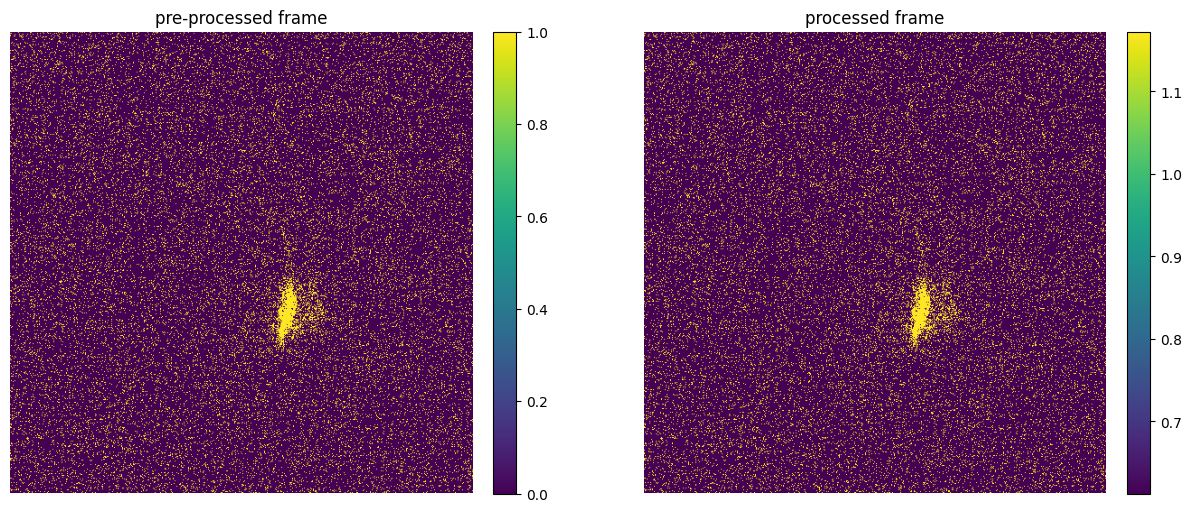

In [13]:
idx, idy = 60, 50  # scan, detector indices


raw_path = Path(r"..\data\000278.h5")
n_scan, n_det, h, w = 141, 121, 512, 1028

with h5py.File(raw_path, "r") as f:
    frames_ds = f["entry/measurement/eiger500k/frames"]

    # Option A: load all then reshape (simple, more RAM)
    # frames_4d = frames_ds[:].reshape(n_scan, n_det, h, w)
    # frame = frames_4d[20, 50]

    # Option B: no full load — index the flat stack and reshape one frame
    flat_idx = idx * n_det + idy
    frame_raw = frames_ds[flat_idx].reshape(h, w)[:,:512]

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.imshow(frame_raw, vmax=np.percentile(frame_raw, 99))
plt.axis("off")
plt.title("pre-processed frame")
plt.colorbar(fraction=0.046, pad=0.04)


path = Path(r"..\data\exports_processed_clean_win0\win00\processed_win00_left512.h5")
with h5py.File(path, "r") as f:
    img = f["img"]
    frame_processed = img[idx,idy]  

plt.subplot(1, 2, 2)
plt.imshow(frame_processed,vmax=np.percentile(frame_processed, 99))
plt.axis("off")
plt.title("processed frame")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

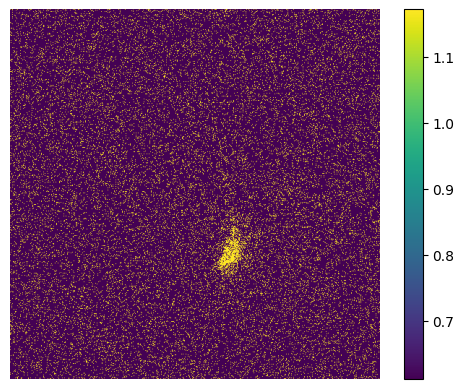

In [ ]:
raw_path = Path(r"..\data\000278.h5")
n_scan, n_det, h, w = 141, 121, 512, 1028

scan_idx = int(input(f"Scan index (0–{n_scan-1}): "))
det_idx  = int(input(f"Det index (0–{n_det-1}): "))

with h5py.File(raw_path, "r") as f:
    frames_ds = f["entry/measurement/eiger500k/frames"]
    flat_idx = scan_idx * n_det + det_idx
    frame = frames_ds[flat_idx].reshape(h, w)

plt.imshow(frame, cmap="gray")
plt.axis("off")
plt.colorbar()
plt.title(f"pre-processed frame [{scan_idx},{det_idx}]")
plt.show()